In [1]:
# We install darts
!pip install u8darts[torch] --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.4/57.4 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.3/46.3 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.6/200.6 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.1/823.1 kB 33.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.4/354.4 kB 30.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 113.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 89.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
from google.colab import drive
drive.mount('/content/drive')

# Necessary imports
import pandas as pd
import zipfile
import os
import numpy as np
import matplotlib.pyplot as plt
import joblib
from darts import TimeSeries
from darts.models import LightGBMModel, BlockRNNModel, TFTModel, BlockRNNModel, ConformalQRModel
from darts.dataprocessing.transformers import Scaler
from darts import concatenate, metrics

# We can ignore Darts library warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

Mounted at /content/drive


In [3]:
# We load the test data
test_data = joblib.load('/content/drive/MyDrive/Colab Notebooks/TFG/data/01_datasets/train_test/scaled_test.pkl')

# Extract components
scaled_calib_test_series = test_data['calib_test']
scalers_test = test_data['scalers']           # the scalers to reescale the series later

# We load the test data specific
test_data_specific = joblib.load('/content/drive/MyDrive/Colab Notebooks/TFG/data/01_datasets/train_test_reduced/scaled_test_reduced.pkl')

# Extract components
scaled_calib_test_series_specific = test_data_specific['calib_test']
scalers_test_specific = test_data_specific['scalers']           # the scalers to reescale the series later

In [4]:
# Stable time series
id = "0810102039_Hospitalet"

# Time serie
ts = scaled_calib_test_series_specific[id]
#ts = scaled_calib_test_series[id]

# Create a unified scaler dictionary for the meters in use
scaler = scalers_test_specific[id]
#scaler = scalers_test[id]


series_dict = {
    id: ts,
}

meter_ids = list(series_dict.keys())

In [5]:

# We load the models
models = {
    "LightGBM": LightGBMModel.load("/content/drive/MyDrive/Colab Notebooks/TFG/data/02_models/lightGBM/simple/lightgbm_model.pkl"),
    "BlockRNN": BlockRNNModel.load("/content/drive/MyDrive/Colab Notebooks/TFG/data/02_models/blockRNN/simple/blockRNN_model.pkl"),
    "TFT": TFTModel.load("/content/drive/MyDrive/Colab Notebooks/TFG/data/02_models/TFT/simple/TFT_model.pkl"),
}

In [6]:
# Constants
start_date = pd.Timestamp("2023-11-6")
quantiles = [0.05, 0.5, 0.95]
pred_kwargs = {"predict_likelihood_parameters": True, "verbose": True}
q_interval = [(0.05, 0.95)]
q_range = [0.9]

# Initialize containers
all_model_results = []
all_hfcs = {}
all_bt_results = {}

# Loop through models
for model_name, model in models.items():
    all_hfcs[model_name] = {}
    all_bt_results[model_name] = {}
    all_hfcs[f"{model_name} CQR"] = {}
    all_bt_results[f"{model_name} CQR"] = {}

    # Wrap base model with CQR
    cp_model = ConformalQRModel(
        model=model,
        quantiles=quantiles,
        symmetric=False
    )
    q_interval = cp_model.q_interval
    q_range = cp_model.interval_range

    # === 1. Original model forecasts ===
    hfcs = model.historical_forecasts(
        series=ts,
        forecast_horizon=7,
        start=start_date,
        last_points_only=False,
        stride=7,
        retrain=False,
        **pred_kwargs,
    )

    # Interval widths
    widths = []
    for forecast in hfcs:
        q05 = forecast["Consumption per meter_q0.05"]
        q95 = forecast["Consumption per meter_q0.95"]
        q05_orig = scaler.inverse_transform(q05)
        q95_orig = scaler.inverse_transform(q95)
        width = (q95_orig - q05_orig).values()
        widths.append(width)
    mean_width = np.mean([np.mean(w) for w in widths])

    # Backtest
    bt = model.backtest(
        ts,
        historical_forecasts=hfcs,
        last_points_only=False,
        metric=[metrics.mic, metrics.miw],
        metric_kwargs={"q_interval": q_interval},
        retrain=False
    )

    df_result = pd.DataFrame({
        "Model": model_name,
        "Meter ID": id,
        "Interval": q_range,
        "Coverage": bt[0],
        "Width": bt[1],
        "Width rescaled": mean_width
    })

    all_model_results.append(df_result)
    all_hfcs[model_name][id] = hfcs
    all_bt_results[model_name][id] = df_result

    # === 2. CQR forecasts ===
    cqr_hfcs = cp_model.historical_forecasts(
        series=ts,
        forecast_horizon=7,
        start=start_date,
        last_points_only=False,
        stride=7,
        **pred_kwargs,
    )

    widths_cqr = []
    for forecast in cqr_hfcs:
        q05 = forecast["Consumption per meter_q0.05"]
        q95 = forecast["Consumption per meter_q0.95"]
        q05_orig = scaler.inverse_transform(q05)
        q95_orig = scaler.inverse_transform(q95)
        width = (q95_orig - q05_orig).values()
        widths_cqr.append(width)
    mean_width_cqr = np.mean([np.mean(w) for w in widths_cqr])

    cqr_bt = cp_model.backtest(
        ts,
        historical_forecasts=cqr_hfcs,
        last_points_only=False,
        retrain=False,
        metric=[metrics.mic, metrics.miw],
        metric_kwargs={"q_interval": q_interval},
    )

    df_cqr_result = pd.DataFrame({
        "Model": f"{model_name} CQR",
        "Meter ID": id,
        "Interval": q_range,
        "Coverage": cqr_bt[0],
        "Width": cqr_bt[1],
        "Width rescaled": mean_width_cqr
    })

    all_model_results.append(df_cqr_result)
    all_hfcs[f"{model_name} CQR"][id] = cqr_hfcs
    all_bt_results[f"{model_name} CQR"][id] = df_cqr_result

# Combine all results
final_results = pd.concat(all_model_results, ignore_index=True)

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 388.17it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 387.78it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 379.46it/s]


In [7]:
final_results

,Model,Meter ID,Interval,Coverage,Width,Width rescaled
0,LightGBM,0810102039_Hospitalet,0.9,0.750000,0.383099,5.807786
1,LightGBM CQR,0810102039_Hospitalet,0.9,0.839286,0.473112,7.172385
2,BlockRNN,0810102039_Hospitalet,0.9,0.892857,0.398614,6.042989
3,BlockRNN CQR,0810102039_Hospitalet,0.9,0.928571,0.498518,7.557529
4,TFT,0810102039_Hospitalet,0.9,0.857143,0.408334,6.190344
5,TFT CQR,0810102039_Hospitalet,0.9,0.910714,0.474449,7.192654


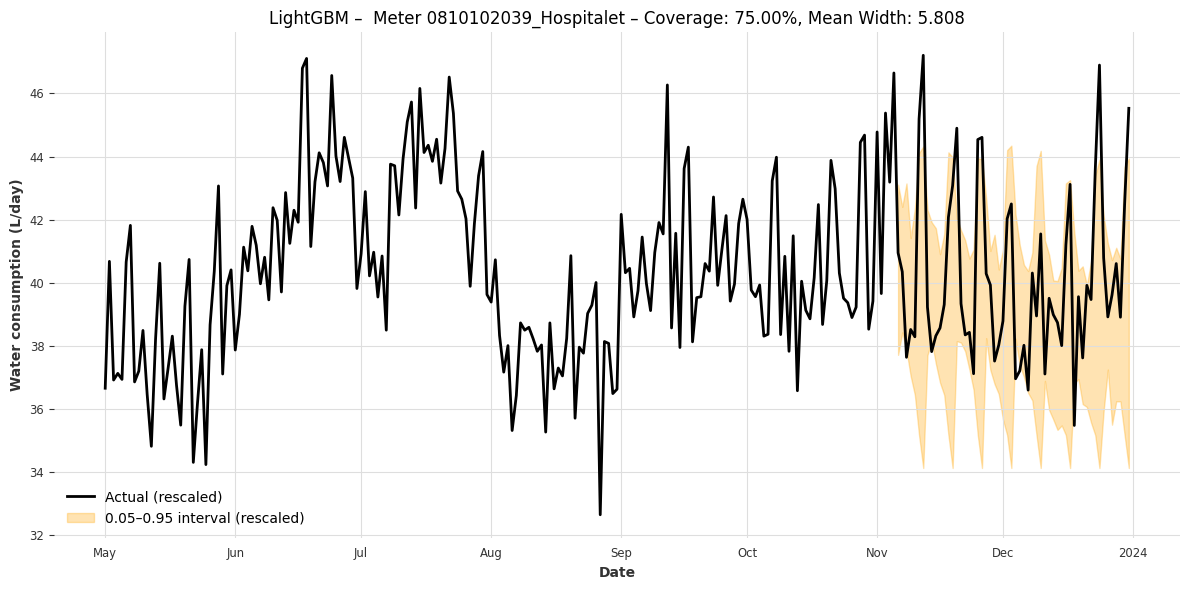

LightGBM | Meter 0810102039_Hospitalet - Coverage: 0.7500, Mean Interval Width (rescaled): 5.8078



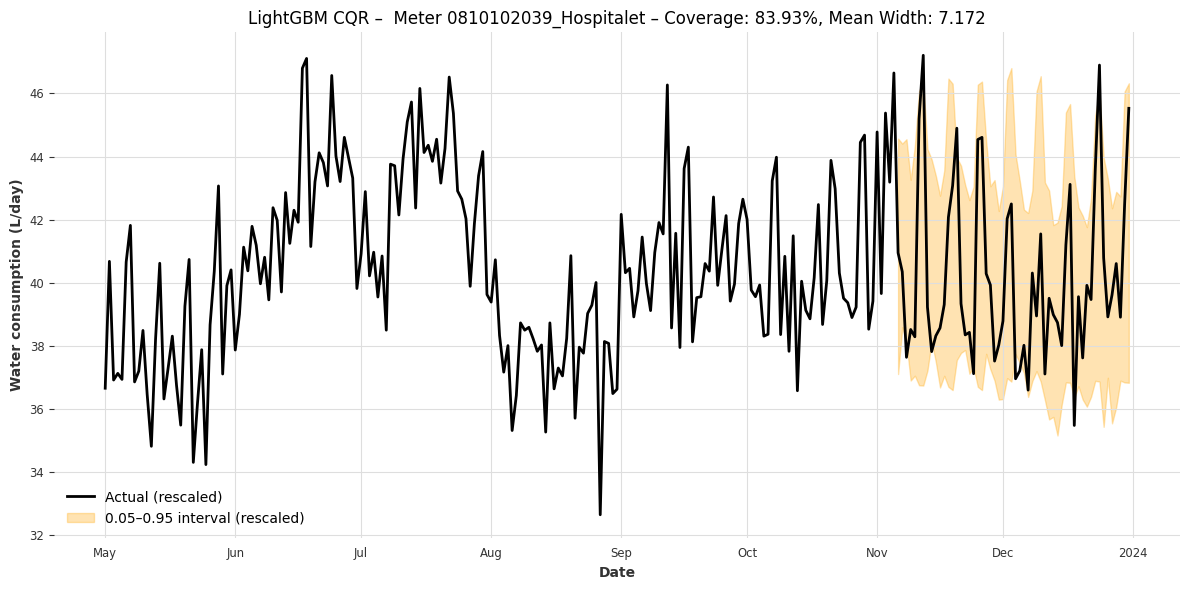

LightGBM CQR | Meter 0810102039_Hospitalet - Coverage: 0.8393, Mean Interval Width (rescaled): 7.1724



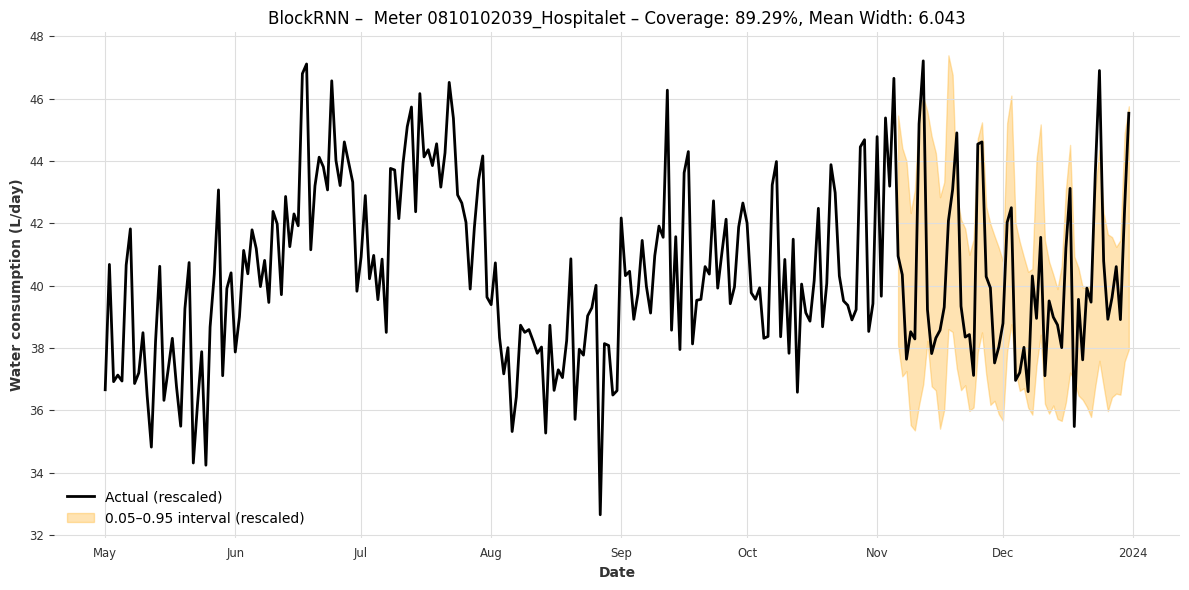

BlockRNN | Meter 0810102039_Hospitalet - Coverage: 0.8929, Mean Interval Width (rescaled): 6.0430



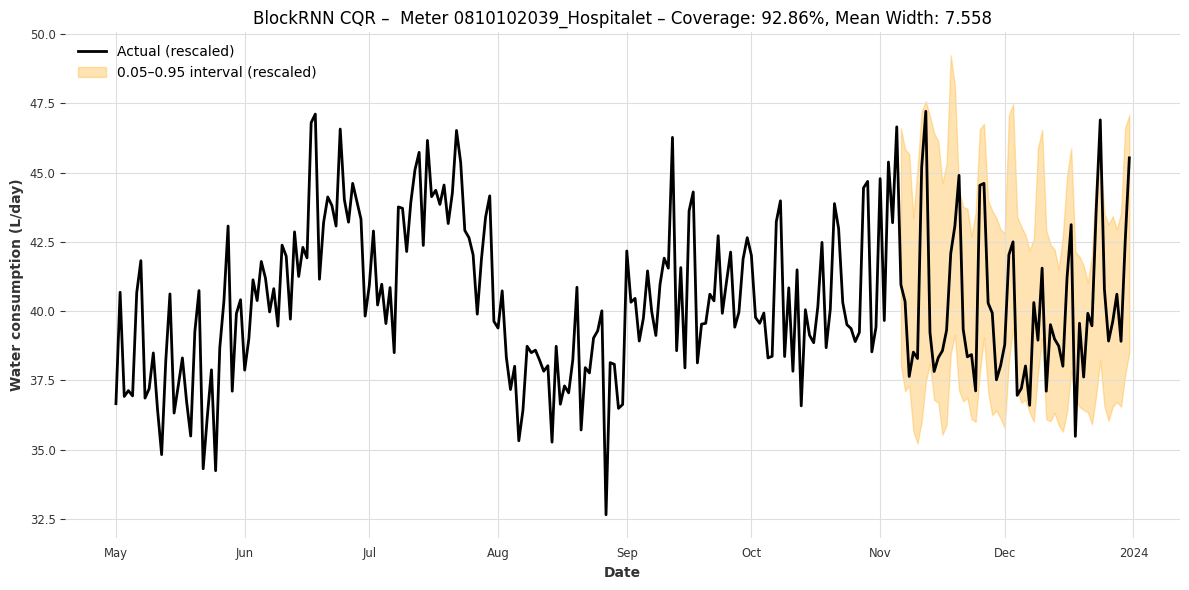

BlockRNN CQR | Meter 0810102039_Hospitalet - Coverage: 0.9286, Mean Interval Width (rescaled): 7.5575



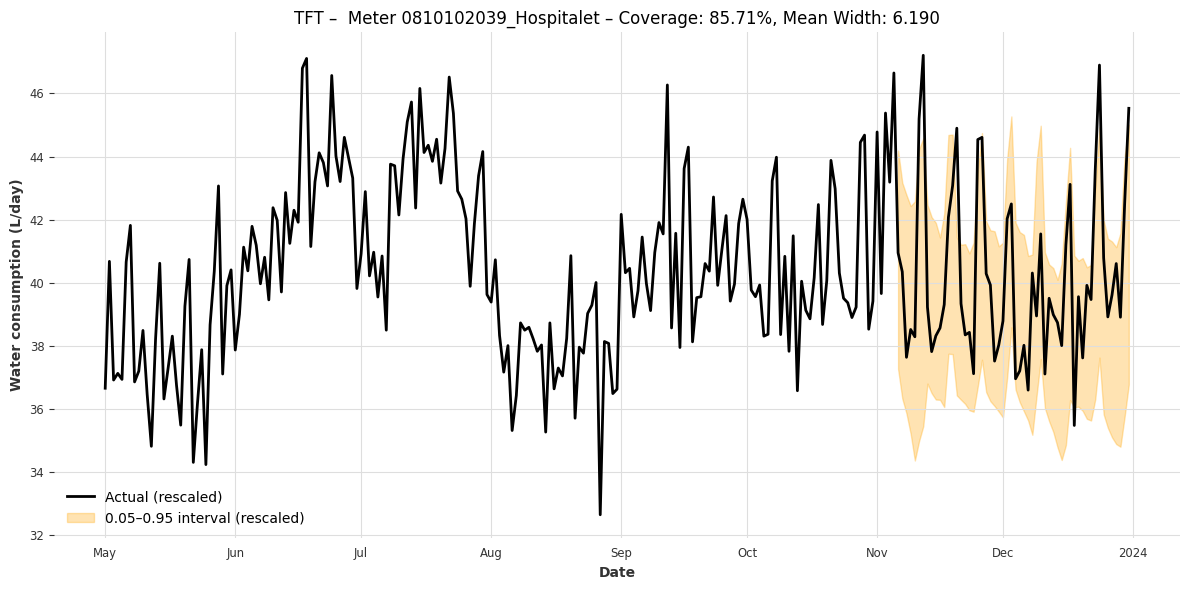

TFT | Meter 0810102039_Hospitalet - Coverage: 0.8571, Mean Interval Width (rescaled): 6.1903



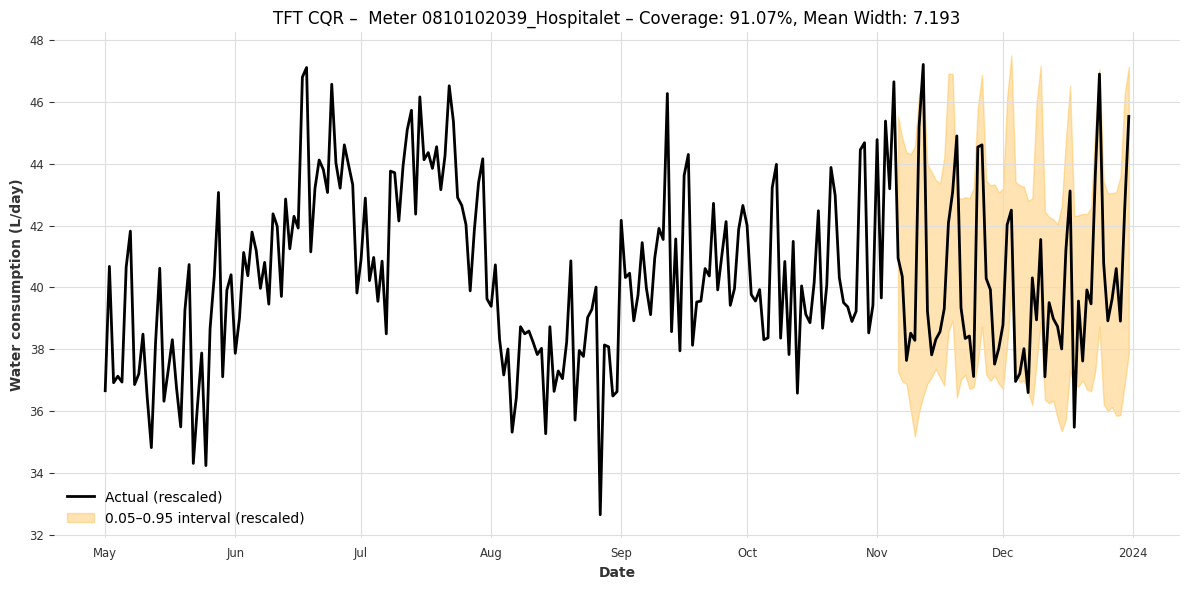

TFT CQR | Meter 0810102039_Hospitalet - Coverage: 0.9107, Mean Interval Width (rescaled): 7.1927



In [8]:
# Define base model order
base_model_names = ["LightGBM", "BlockRNN", "TFT"]

# Loop through each meter
ts_orig = scaler.inverse_transform(ts)

for model_name in base_model_names:
    for variant in [model_name, f"{model_name} CQR"]:

        hfcs = all_hfcs[variant][id]
        df_result = all_bt_results[variant][id]

        # Metrics
        coverage = df_result["Coverage"].iloc[0]
        width = df_result["Width rescaled"].iloc[0]

        # Plot setup
        fig, ax = plt.subplots(figsize=(12, 6))
        ts_orig.plot(ax=ax, label="Actual (rescaled)", lw=2)

        # Collect forecast intervals
        full_lower = []
        full_upper = []

        for forecast in hfcs:
            if ("Consumption per meter_q0.05" in forecast.components and
                "Consumption per meter_q0.95" in forecast.components):

                lower = forecast["Consumption per meter_q0.05"]
                upper = forecast["Consumption per meter_q0.95"]
                lower_orig = scaler.inverse_transform(lower)
                upper_orig = scaler.inverse_transform(upper)

                full_lower.append(lower_orig)
                full_upper.append(upper_orig)

        # Plot intervals
        if full_lower and full_upper:
            combined_lower = concatenate(full_lower)
            combined_upper = concatenate(full_upper)

            ax.fill_between(
                combined_lower.time_index,
                combined_lower.values().flatten(),
                combined_upper.values().flatten(),
                color="orange",
                alpha=0.3,
                label="0.05–0.95 interval (rescaled)"
            )


        ax.set_title(f"{variant} –  Meter {id} – Coverage: {coverage:.2%}, Mean Width: {width:.3f}")
        ax.set_ylabel("Water consumption (L/day)")
        ax.legend()
        plt.tight_layout()

        filename = f"/content/drive/MyDrive/Colab Notebooks/TFG/05_examples/{variant.replace(' ', '_')}_meter_{id}.png"
        plt.savefig(filename, dpi=300)


        plt.show()

        # Print metrics
        print(f"{variant} | Meter {id} - Coverage: {coverage:.4f}, Mean Interval Width (rescaled): {width:.4f}\n")
